In [8]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from time import strftime
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from nltk import sent_tokenize, word_tokenize

import tensorflow as tf
from keras.models import Model
from keras import optimizers, backend as K
from keras.backend.tensorflow_backend import _to_tensor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Embedding, Dropout, Dense, TimeDistributed

dataset_name = 'small'
n_cats = 5 
is_GPU = False # False
n_units = 50
max_doc_size_overall = 20 # max nb of sentences allowed per document
max_sent_size_overall = 50 # max nb of words allowed per sentence
drop_rate = 0.45
my_loss = 'categorical_crossentropy'

# replace with your own!
path_root = '/home/dongwenjian/projet3A/data/' + dataset_name + '/'
path_to_batches = path_root + '/batches/'
path_to_save = '/home/dongwenjian/projet3A/results/' + dataset_name + '/'
path_to_functions = '/home/dongwenjian/projet3A/codes/'

# custom classes and functions
sys.path.insert(0, path_to_functions)
from AttentionWithContext import AttentionWithContext
from CyclicalLearningRate import CyclicLR
from CyclicalMomentum import CyclicMT
from han_my_functions import read_batches, bidir_gru, PerClassAccHistory, LossHistory, AccHistory, LRHistory, MTHistory

In [2]:
'''
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
fname = get_tmpfile("vectors.kv")#This function return the corresponding file name with absolute path. 
            #It doesn't create any file
word_vectors.save(fname)

#I write this line, suppose the author's word_vector is the same with the one above 
gensim_obj = KeyedVectors.load(fname, mmap='r')

#gensim_obj = KeyedVectors.load(path_root + 'word_vectors.kv', mmap='r') # needs an absolute path!
word_vecs = gensim_obj.wv.syn0
# add Gaussian initialized vector on top of embedding matrix (for padding)  #?? Why padding with gaussian noise??
pad_vec = np.random.normal(size=word_vecs.shape[1]) 
word_vecs = np.insert(word_vecs,0,pad_vec,0)
'''

In [3]:
gensim_obj = KeyedVectors.load(path_root + 'word_vectors.kv', mmap='r') # needs an absolute path!
word_vecs = gensim_obj.wv.syn0
# add Gaussian initialized vector on top of embedding matrix (for padding)
pad_vec = np.random.normal(size=word_vecs.shape[1]) 
word_vecs = np.insert(word_vecs,0,pad_vec,0)

In [4]:
sent_ints = Input(shape=(None,))  # input is one-hot vectors, or index vectors?
sent_wv = Embedding(input_dim=word_vecs.shape[0],
                    output_dim=word_vecs.shape[1],
                    weights=[word_vecs], # To set the initial weights
                    input_length=None, # sentence size vary from batch to batch
                    trainable=True
                    )(sent_ints)

sent_wv_dr = Dropout(drop_rate)(sent_wv)
sent_wa = bidir_gru(sent_wv_dr,n_units,is_GPU) # annotations for each word in the sentence
sent_att_vec,sent_att_coeffs = AttentionWithContext(return_coefficients=True)(sent_wa) # attentional vector for the sentence
sent_att_vec_dr = Dropout(drop_rate)(sent_att_vec)                      
sent_encoder = Model(sent_ints,sent_att_vec_dr)

print(sent_wa.shape)
print(sent_att_vec_dr.shape)

(?, ?, 100)
(?, 100)


In [5]:
doc_ints = Input(shape=(None,None,))        
sent_att_vecs_dr = TimeDistributed(sent_encoder)(doc_ints)
doc_sa = bidir_gru(sent_att_vecs_dr,n_units,is_GPU) # annotations for each sentence in the document
doc_att_vec,doc_att_coeffs = AttentionWithContext(return_coefficients=True)(doc_sa) # attentional vector for the document
doc_att_vec_dr = Dropout(drop_rate)(doc_att_vec)

print(sent_att_vecs_dr.shape)
print(doc_sa.shape)
print(doc_att_vec_dr.shape)

(?, ?, 100)
(?, ?, 100)
(?, 100)


In [9]:
preds = Dense(units=n_cats,
              activation='softmax')(doc_att_vec_dr)

han = Model(doc_ints,preds)
# so that we can just load the initial weights instead of redifining the model later on
han.save_weights(path_to_save + 'han_init_weights')

print(preds.shape)

(?, 5)


In [ ]:
#Learning rate tests

In [10]:
base_mt, max_mt = 0.85, 0.95
batch_names = os.listdir(path_to_batches)
batch_names_train = [elt for elt in batch_names if 'train_' in elt or 'val_' in elt]
its_per_epoch_train = int(len(batch_names_train)/2) # /2 because there are batches for documents and labels

nb_epochs = 6
step_size = its_per_epoch_train*nb_epochs
base_lr, max_lr = 0.001, 3

In [11]:
my_optimizer = optimizers.SGD(lr=base_lr,
                              momentum=max_mt, # we decrease momentum when lr increases
                              decay=1e-5,
                              nesterov=True)

han.compile(loss=my_loss,
            optimizer=my_optimizer,
            metrics=['accuracy'])

lr_sch = CyclicLR(base_lr=base_lr, 
                  max_lr=max_lr, 
                  step_size=step_size, 
                  mode='triangular')

mt_sch = CyclicMT(base_mt=base_mt, 
                  max_mt=max_mt, 
                  step_size=step_size, 
                  mode='triangular')

# batch-based callbacks
loss_hist = LossHistory()
acc_hist = AccHistory()
lr_hist = LRHistory()
mt_hist = MTHistory() 

# ! the order of the callbacks matters! If lr_sch before lr_callback, the new learning rate will be saved (not the current epoch's)
callback_list = [loss_hist, acc_hist, lr_hist, mt_hist, lr_sch, mt_sch]

In [12]:
rd_train = read_batches(batch_names_train,
                        path_to_batches,
                        do_shuffle=True,
                        do_train=True,
                        my_max_doc_size_overall=max_doc_size_overall,
                        my_max_sent_size_overall=max_sent_size_overall,
                        my_n_cats=n_cats)

In [13]:
han.fit_generator(rd_train, 
                  steps_per_epoch=its_per_epoch_train, 
                  epochs=nb_epochs,
                  callbacks=callback_list,
                  validation_data=None, 
                  validation_steps=None,
                  use_multiprocessing=False, # only works with keras.utils.Sequence class (duplicate batches when used with generators)
                  workers=1)

Epoch 1/6
28/28 [==============================] - 32s 1s/step - loss: 1.6393 - acc: 0.2039
Epoch 2/6
28/28 [==============================] - 33s 1s/step - loss: 1.6979 - acc: 0.2199
Epoch 3/6
28/28 [==============================] - 30s 1s/step - loss: nan - acc: 0.1856
Epoch 4/6
28/28 [==============================] - 30s 1s/step - loss: nan - acc: 0.1949
Epoch 5/6
28/28 [==============================] - 32s 1s/step - loss: nan - acc: 0.1949
Epoch 6/6
28/28 [==============================] - 32s 1s/step - loss: nan - acc: 0.1949


In [14]:
hist = han.history.history
hist['batch_loss'] = loss_hist.loss_avg
hist['batch_acc'] = acc_hist.acc_avg
hist['batch_lr'] = lr_hist.lrs
hist['batch_mt'] = mt_hist.mts

hist = {k: [str(elt) for elt in v] for k, v in hist.items()}
with open(path_to_save + 'han_lr_range_test_trainval_history.json', 'w') as my_file:
    json.dump(hist, my_file, sort_keys=False, indent=4)


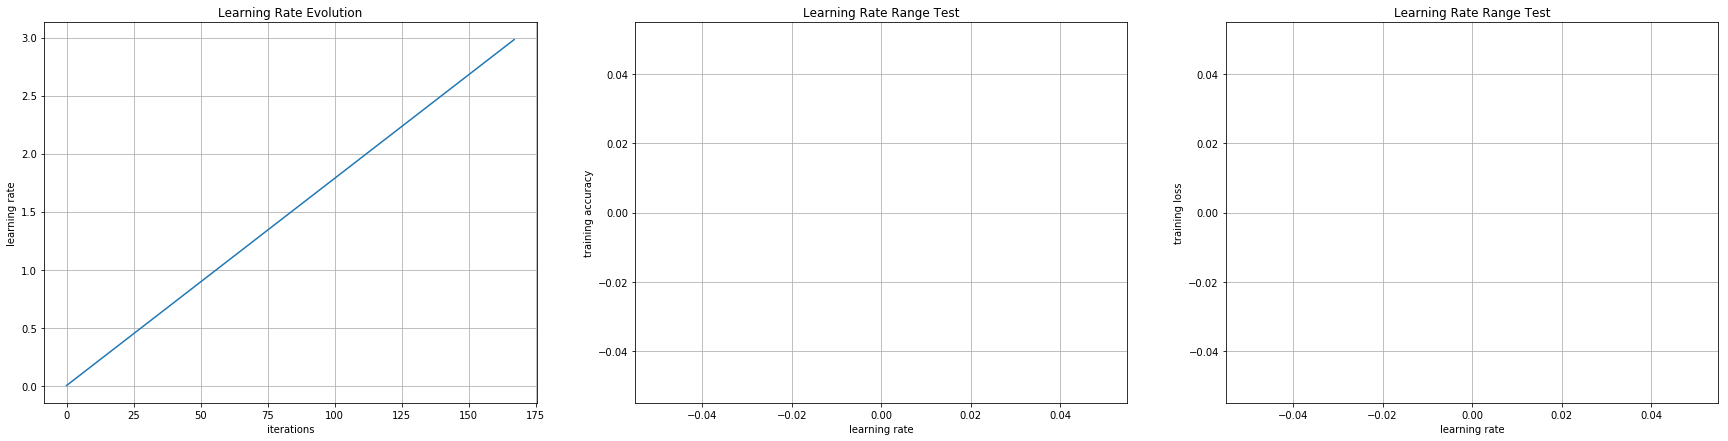

In [15]:
with open(path_to_save + 'han_lr_range_test_trainval_history.json' , 'r', encoding='utf8') as my_file:
    hist = json.load(my_file)

hist = {k:list(map(float,v)) for k,v in hist.items()} # convert strings to floats

n_its_plot = 2000
acc_plot = [elt for idx,elt in enumerate(hist['batch_acc'],1) if idx%n_its_plot==0]
loss_plot = [elt for idx,elt in enumerate(hist['batch_loss'],1) if idx%n_its_plot==0]
lr_plot = [elt for idx,elt in enumerate(hist['batch_lr'],1) if idx%n_its_plot==0]

fig = plt.figure(figsize=(30,7))

plt.subplot(1,3,1)
plt.plot(range(len(hist['batch_lr'])),hist['batch_lr'])
plt.xlabel('iterations')
plt.ylabel('learning rate')
plt.grid(True)
plt.title('Learning Rate Evolution')

plt.subplot(1,3,2)
plt.plot(lr_plot,acc_plot)
plt.xlabel('learning rate')
plt.ylabel('training accuracy')
plt.grid(True)
plt.title('Learning Rate Range Test')

plt.subplot(1,3,3)
plt.plot(lr_plot,loss_plot)
plt.xlabel('learning rate')
plt.ylabel('training loss')
plt.grid(True)
plt.title('Learning Rate Range Test')

plt.show()

In [14]:
numberList = [1, 2, 3]
strList = ['one', 'two', 'three']
for (i, a) in zip(numberList, strList):
    print(i,a)

1 one
2 two
3 three


In [21]:
a = 123
print(a if a > 0)

SyntaxError: invalid syntax (<ipython-input-21-def8bed8b7f0>, line 2)

In [18]:
[elt for elt in strList if 't' in elt]

['two', 'three']

In [22]:
[elt for elt in numberList if elt > 1.5]

[2, 3]

In [24]:
print('\d')

\d+
